In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
from torchvision.transforms import v2 as transforms
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
import click

import train

Files already downloaded and verified


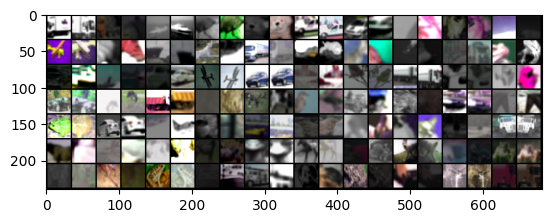

In [9]:
# This transform returns 2 copies of every image
transform = train.simCLR_transform()

cifarTest = train.CIFAR10_Paired(
    root="./data", train=False, download=True, transform=transform
)
testLoader = DataLoader(cifarTest, batch_size=70, shuffle=True)

# Get a batch (and reshape to handle double images)
images, labels = next(iter(testLoader))
shape = images.shape
images = images.view(shape[0] * 2, shape[2], shape[3], shape[4])

# Display grid
grid = torchvision.utils.make_grid(images, nrow=20)
grid = np.transpose(grid, (1, 2, 0))

_ = plt.imshow(grid)

In [10]:
# Load CNN
model = train.cnn_simCLR()
model.load_state_dict(torch.load("unsupervised.pth"))
model.eval()

# Get the normal test set of CIFAR10
cifarTest = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
testLoader = DataLoader(cifarTest, batch_size=156, shuffle=True)

# Get the embeddings from some images
targetImages = 1000
imgCount = 0
embeddings = []
cats = []
for images, labels in testLoader:
    with torch.no_grad():
        embeddings.append(model(images))
    cats.append(labels)

    imgCount += len(labels)
    if imgCount >= targetImages:
        break

embeddings = torch.cat(embeddings)
cats = torch.cat(cats)

Files already downloaded and verified


In [11]:
embeddings.shape

torch.Size([1092, 128])

Text(0.5, 1.0, 'MDS of CIFAR10 embeddings')

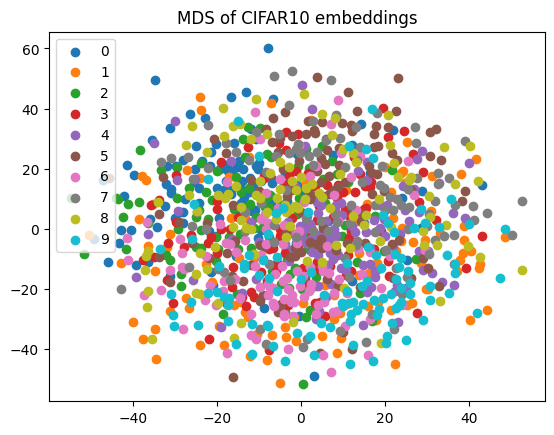

In [12]:
# Do MDS on embeddings
mds = MDS(n_components=2)
mdsEmbeddings = mds.fit_transform(embeddings)

# Plot the embeddings
plt.figure()
for i in range(10):
    mask = cats == i
    plt.scatter(mdsEmbeddings[mask, 0], mdsEmbeddings[mask, 1], label=str(i))
plt.legend()
plt.title("MDS of CIFAR10 embeddings")

In [13]:
# Modify the model to be a linear classifier
class simClr_classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = train.cnn_simCLR()
        self.encoder.load_state_dict(torch.load("unsupervisedBackup.pth"))

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

In [15]:
model = simClr_classifier()
model = model.cuda()
print(summary(model))

transform = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]
)
cifarTrain = CIFAR10(root="./data", train=True, download=True, transform=transform)
cifarTest = CIFAR10(root="./data", train=False, download=True, transform=transform)

trainLoader = DataLoader(cifarTrain, batch_size=128, shuffle=True)
testLoader = DataLoader(cifarTest, batch_size=128, shuffle=False)

lossFun = nn.CrossEntropyLoss()
sgd = optim.SGD(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-6,
)


for epoch in range(10):
    trainLosses = []
    trainAccs = []

    model.train()

    with click.progressbar(
        length=len(trainLoader),
        label="Train",
        item_show_func=lambda x: (
            f"Loss: {x[0]:5.3f}  Acc: {x[1]:5.3f}" if x is not None else None
        ),
    ) as bar:
        for images, labels in trainLoader:
            images = images.cuda()
            labels = labels.cuda()

            # Zero out gradients
            sgd.zero_grad()

            # Get outputs
            output = model(images)

            # Calculate loss
            loss = lossFun(output, labels)

            # Record metrics
            trainLosses += [loss.item()]
            trainAccs += [(output.argmax(1) == labels).sum().item() / len(labels)]

            # Update weights
            loss.backward()
            sgd.step()

            bar.update(
                1,
                [
                    np.mean(trainLosses),
                    np.mean(trainAccs),
                ],
            )

    # Validation loop
    model.eval()
    with torch.no_grad():
        testLoss = 0.0
        testAcc = 0.0

        with click.progressbar(testLoader, label="Test ") as bar:
            for images, labels in bar:
                images = images.cuda()
                labels = labels.cuda()

                output = model(images)
                loss = lossFun(output, labels)

                testLoss += loss.item()
                testAcc += (output.argmax(1) == labels).sum().item()

        testLoss /= len(testLoader)
        testAcc /= len(cifarTest)

    click.echo(
        f"Epoch {epoch + 1}: Train Loss: {np.mean(trainLosses):5.3f}, Train Accuracy: {np.mean(trainAccs):5.3f}, Test Loss: {testLoss:5.3f}, Test Accuracy: {testAcc:5.3f}"
    )

Layer (type:depth-idx)                   Param #
simClr_classifier                        --
├─cnn_simCLR: 1-1                        --
│    └─cnn: 2-1                          --
│    │    └─Sequential: 3-1              (85,728)
│    │    └─Sequential: 3-2              (498,048)
│    └─Sequential: 2-2                   --
│    │    └─Flatten: 3-3                 --
│    │    └─LazyLinear: 3-4              (1,572,992)
│    │    └─ReLU: 3-5                    --
│    │    └─LazyLinear: 3-6              (16,512)
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       16,512
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       1,290
Total params: 2,191,082
Trainable params: 17,802
Non-trainable params: 2,173,280
Files already downloaded and verified
Files already downloaded and verified
Train
Test 
Epoch 1: Train Loss: 1.593, Train Accuracy: 0.450, Test Loss: 1.332, Test Accuracy: 0.533
Train
Test 
Epoch 2: Train Loss: 1.297, T